# Imports

In [241]:
import json, random
import sys, statistics

In [242]:
from market import Market, Produto

In [243]:
from PIL import Image
from IPython.display import display
import plotly.graph_objects as go
from collections import Counter

# Static Values

In [244]:
CART: dict = {
    'Altura': 65,
    'Largura': 50,
    'Comprimento': 80,
    'PesoMaximo': 460*1000
}

CART['Capacidade'] = CART['Altura'] * CART['Largura'] * CART['Comprimento']

CART

{'Altura': 65,
 'Largura': 50,
 'Comprimento': 80,
 'PesoMaximo': 460000,
 'Capacidade': 260000}

In [245]:
MAX_MONEY: float = 1200.0
MAX_ITEMS: int = 30
MAX_CARTS: int = 100
MAX_GENERATIONS: int = 1500
BESTS: int = 9

# Funções

In [246]:
m: Market = Market(r"C:\Users\Arklok\Documents\Projetos\gen-algorithm\data\produtos.csv")

In [247]:
def mosaic(cart: list[Produto], row_quantity: int = 5, image_size: tuple[int, int] = (300, 300)) -> None:
    images: list[Image] = [product.show(popup=False).resize(image_size) for product in cart]
    
    mosaic_size: tuple[int, int] = (image_size[0]*row_quantity, image_size[1]*((len(images)//row_quantity)+1))
    
    mosaic: Image = Image.new('RGB', mosaic_size)
    
    for i, image in enumerate(images):
        mosaic.paste(image, (image_size[0]*(i%row_quantity), image_size[1]*(i//row_quantity)))
    
    display(mosaic) 

In [248]:
def plot_generations(data):
    # Extraindo as iterações e os valores
    iterations = list(data.keys())
    max_values = [data[i]['max'] for i in iterations]
    min_values = [data[i]['min'] for i in iterations]
    avg_values = [data[i]['med'] for i in iterations]

    # Criando o gráfico
    fig = go.Figure()

    # Adicionando as linhas para cada tipo
    fig.add_trace(go.Scatter(x=iterations, y=max_values, mode='lines+markers', name='Max'))
    fig.add_trace(go.Scatter(x=iterations, y=min_values, mode='lines+markers', name='Min'))
    fig.add_trace(go.Scatter(x=iterations, y=avg_values, mode='lines+markers', name='Medio'))

    # Adicionando título e rótulos
    fig.update_layout(title='Gráfico de Gerações',
                      xaxis_title='Iteração',
                      yaxis_title='Valores',
                      template='plotly')

    # Exibindo o gráfico
    fig.show()

In [249]:
def calculate_regression(data: dict, last: int = 10) -> float:
    if len(data) < last:
        return float("inf")
    
    else:
        values: list = list(data.values())[-last:]
        return statistics.stdev([value.get('min') for value in values])

# Genético

### Geração de Indivíduos

In [250]:
def gerar_carrinho(tamanho: int = globals()['MAX_ITEMS']) -> list[Produto]:
    compra = []

    while len(compra) < tamanho:
        item: Produto = m.random()
        compra.append(item)
        
    return compra

In [251]:
c: list[Produto] = gerar_carrinho()
c

[<Produto(id=245703>,
 <Produto(id=287859>,
 <Produto(id=302930>,
 <Produto(id=457552>,
 <Produto(id=1111951>,
 <Produto(id=1309018>,
 <Produto(id=290020>,
 <Produto(id=1387081>,
 <Produto(id=670165>,
 <Produto(id=126657>,
 <Produto(id=1618531>,
 <Produto(id=34660>,
 <Produto(id=144930>,
 <Produto(id=284478>,
 <Produto(id=97185>,
 <Produto(id=383831>,
 <Produto(id=463526>,
 <Produto(id=62145>,
 <Produto(id=1420972>,
 <Produto(id=5728>,
 <Produto(id=421225>,
 <Produto(id=472881>,
 <Produto(id=145948>,
 <Produto(id=336102>,
 <Produto(id=1111953>,
 <Produto(id=1621455>,
 <Produto(id=1376290>,
 <Produto(id=1623218>,
 <Produto(id=1625253>,
 <Produto(id=328080>]

### Geração de População Inicial

In [252]:
def gerar_populacao(tamanho: int = globals()['MAX_CARTS']) -> list[list[Produto]]:
    return [gerar_carrinho() for _ in range(tamanho)]

In [253]:
p: list[list[Produto]] = gerar_populacao()
p

[[<Produto(id=1615748>,
  <Produto(id=383831>,
  <Produto(id=419003>,
  <Produto(id=478808>,
  <Produto(id=411008>,
  <Produto(id=339013>,
  <Produto(id=43804>,
  <Produto(id=479389>,
  <Produto(id=326862>,
  <Produto(id=446660>,
  <Produto(id=409358>,
  <Produto(id=324113>,
  <Produto(id=1440452>,
  <Produto(id=454910>,
  <Produto(id=431868>,
  <Produto(id=323696>,
  <Produto(id=25267>,
  <Produto(id=1446530>,
  <Produto(id=15428>,
  <Produto(id=181460>,
  <Produto(id=440145>,
  <Produto(id=168387>,
  <Produto(id=711992>,
  <Produto(id=11113>,
  <Produto(id=1375784>,
  <Produto(id=142418>,
  <Produto(id=1616576>,
  <Produto(id=195417>,
  <Produto(id=1623169>,
  <Produto(id=25181>],
 [<Produto(id=1624417>,
  <Produto(id=1377277>,
  <Produto(id=116609>,
  <Produto(id=282816>,
  <Produto(id=13204>,
  <Produto(id=1566833>,
  <Produto(id=1628300>,
  <Produto(id=418132>,
  <Produto(id=315604>,
  <Produto(id=365816>,
  <Produto(id=407910>,
  <Produto(id=182374>,
  <Produto(id=145948>,
  <Pro

### Avaliação

In [254]:
def avaliar(individuo: list[Produto]) -> float:
    valor_compra: float = 0.0
    penalidade: float = 0.0
    bonus: float = 0.0
    categorias: set = set()

    for item in individuo:
        valor_compra += item.price
        categorias.add(item.category)

        if individuo.count(item) > 1:
            penalidade += individuo.count(item)*2

    bonus += len(categorias)*5

    if valor_compra > globals()['MAX_MONEY']:
        penalidade += (valor_compra - globals()['MAX_MONEY'])*3
    
    return (valor_compra + penalidade - bonus)**2

In [255]:
n: float = avaliar(c)
n

574518.5209

In [256]:
def mapear_notas(populacao: list[list[Produto]], order: str = 'asc') -> dict[float, list[Produto]]:
    notas: dict = {avaliar(individuo): individuo for individuo in populacao}
    
    if order == 'asc':
        return dict(sorted(notas.items()))
    
    else:
        return dict(sorted(notas.items(), reverse=True))

In [257]:
nt: dict[float, list[Produto]] = mapear_notas(p)
nt

{247605.76: [<Produto(id=330856>,
  <Produto(id=427413>,
  <Produto(id=128632>,
  <Produto(id=31313>,
  <Produto(id=225199>,
  <Produto(id=472426>,
  <Produto(id=796084>,
  <Produto(id=456448>,
  <Produto(id=478018>,
  <Produto(id=585390>,
  <Produto(id=672258>,
  <Produto(id=354327>,
  <Produto(id=314717>,
  <Produto(id=427067>,
  <Produto(id=459782>,
  <Produto(id=1616281>,
  <Produto(id=181459>,
  <Produto(id=164065>,
  <Produto(id=128337>,
  <Produto(id=44486>,
  <Produto(id=81476>,
  <Produto(id=1566833>,
  <Produto(id=339050>,
  <Produto(id=12628>,
  <Produto(id=154280>,
  <Produto(id=127976>,
  <Produto(id=328762>,
  <Produto(id=54940>,
  <Produto(id=1111953>,
  <Produto(id=140452>],
 248711.66410000014: [<Produto(id=1944>,
  <Produto(id=1599122>,
  <Produto(id=55835>,
  <Produto(id=141168>,
  <Produto(id=1614042>,
  <Produto(id=340565>,
  <Produto(id=339050>,
  <Produto(id=470254>,
  <Produto(id=1377278>,
  <Produto(id=379876>,
  <Produto(id=438223>,
  <Produto(id=528838>,
  <P

### Seleção

In [258]:
def torneio(populacao: list[list[Produto]]) -> list[list[Produto]]:
    vencedores: list[list[Produto] | None] = []
    
    while len(vencedores) < 2:
        competidor_1: list[Produto] = random.choice(populacao)
        competidor_2: list[Produto] = random.choice(populacao)
                
        # Seleção do melhor individuo:
        if avaliar(competidor_1) < avaliar(competidor_2):
            vencedor: list[Produto] = competidor_1
        
        elif avaliar(competidor_1) > avaliar(competidor_2):
            vencedor: list[Produto] = competidor_2
            
        else:
            vencedor: list[Produto] = random.choice([competidor_1, competidor_2])
            
        if vencedor not in vencedores:
            vencedores.append(vencedor)
    
    return vencedores

In [259]:
v1: list[list[Produto]] = torneio(p)
v1

[[<Produto(id=1615748>,
  <Produto(id=383831>,
  <Produto(id=419003>,
  <Produto(id=478808>,
  <Produto(id=411008>,
  <Produto(id=339013>,
  <Produto(id=43804>,
  <Produto(id=479389>,
  <Produto(id=326862>,
  <Produto(id=446660>,
  <Produto(id=409358>,
  <Produto(id=324113>,
  <Produto(id=1440452>,
  <Produto(id=454910>,
  <Produto(id=431868>,
  <Produto(id=323696>,
  <Produto(id=25267>,
  <Produto(id=1446530>,
  <Produto(id=15428>,
  <Produto(id=181460>,
  <Produto(id=440145>,
  <Produto(id=168387>,
  <Produto(id=711992>,
  <Produto(id=11113>,
  <Produto(id=1375784>,
  <Produto(id=142418>,
  <Produto(id=1616576>,
  <Produto(id=195417>,
  <Produto(id=1623169>,
  <Produto(id=25181>],
 [<Produto(id=330856>,
  <Produto(id=427413>,
  <Produto(id=128632>,
  <Produto(id=31313>,
  <Produto(id=225199>,
  <Produto(id=472426>,
  <Produto(id=796084>,
  <Produto(id=456448>,
  <Produto(id=478018>,
  <Produto(id=585390>,
  <Produto(id=672258>,
  <Produto(id=354327>,
  <Produto(id=314717>,
  <Produto

In [260]:
def roleta_viciada(populacao: list[list[Produto]]) -> list[list[Produto]]:
    fitness_list: list[float] = [1 / avaliar(individuo) for individuo in populacao]
    total_fitness: float = sum(fitness_list)
    probabilities: list[float] = [fitness / total_fitness for fitness in fitness_list]
    
    vencedores: list[list[Produto]] = random.choices(populacao, weights=probabilities, k=2)
    
    return vencedores

In [261]:
v2: list[list[Produto]] = roleta_viciada(p)
v2

[[<Produto(id=1246070>,
  <Produto(id=465035>,
  <Produto(id=161459>,
  <Produto(id=395827>,
  <Produto(id=434779>,
  <Produto(id=395827>,
  <Produto(id=334119>,
  <Produto(id=74949>,
  <Produto(id=354327>,
  <Produto(id=418932>,
  <Produto(id=30116>,
  <Produto(id=74109>,
  <Produto(id=379840>,
  <Produto(id=397282>,
  <Produto(id=217087>,
  <Produto(id=220254>,
  <Produto(id=395827>,
  <Produto(id=53706>,
  <Produto(id=431868>,
  <Produto(id=1616293>,
  <Produto(id=11672>,
  <Produto(id=134588>,
  <Produto(id=128990>,
  <Produto(id=388942>,
  <Produto(id=328613>,
  <Produto(id=421704>,
  <Produto(id=112743>,
  <Produto(id=1621455>,
  <Produto(id=1618987>,
  <Produto(id=182444>],
 [<Produto(id=176191>,
  <Produto(id=1606864>,
  <Produto(id=568623>,
  <Produto(id=379836>,
  <Produto(id=427413>,
  <Produto(id=144930>,
  <Produto(id=1616483>,
  <Produto(id=643580>,
  <Produto(id=457551>,
  <Produto(id=715822>,
  <Produto(id=306328>,
  <Produto(id=197994>,
  <Produto(id=1616960>,
  <Produ

In [262]:
def eugenia(populacao: list[list[Produto]], order: str = 'asc') -> list[list[Produto]]:
    notas: dict[float, list[Produto]] = mapear_notas(populacao, order)
    melhores: list[list[Produto]] = list(notas.values())[:globals()['BESTS']]
    
    return melhores

In [263]:
e: list[list[Produto]] = eugenia(p)
e

[[<Produto(id=330856>,
  <Produto(id=427413>,
  <Produto(id=128632>,
  <Produto(id=31313>,
  <Produto(id=225199>,
  <Produto(id=472426>,
  <Produto(id=796084>,
  <Produto(id=456448>,
  <Produto(id=478018>,
  <Produto(id=585390>,
  <Produto(id=672258>,
  <Produto(id=354327>,
  <Produto(id=314717>,
  <Produto(id=427067>,
  <Produto(id=459782>,
  <Produto(id=1616281>,
  <Produto(id=181459>,
  <Produto(id=164065>,
  <Produto(id=128337>,
  <Produto(id=44486>,
  <Produto(id=81476>,
  <Produto(id=1566833>,
  <Produto(id=339050>,
  <Produto(id=12628>,
  <Produto(id=154280>,
  <Produto(id=127976>,
  <Produto(id=328762>,
  <Produto(id=54940>,
  <Produto(id=1111953>,
  <Produto(id=140452>],
 [<Produto(id=1944>,
  <Produto(id=1599122>,
  <Produto(id=55835>,
  <Produto(id=141168>,
  <Produto(id=1614042>,
  <Produto(id=340565>,
  <Produto(id=339050>,
  <Produto(id=470254>,
  <Produto(id=1377278>,
  <Produto(id=379876>,
  <Produto(id=438223>,
  <Produto(id=528838>,
  <Produto(id=1623218>,
  <Produto(

### Crossover e Mutação

In [264]:
def cruzamento(pais: list[list[Produto]], chance: float = 0.8) -> list[list[Produto]]:
    pai_1: list[Produto] = pais[0]
    pai_2: list[Produto] = pais[1]

    probabilidade: float = round(random.uniform(0, 1), 2)

    if probabilidade < chance:
        pos: int = random.randint(0, len(pai_1))

        filho_1: list[Produto] = pai_1[:pos] + pai_2[pos:]
        filho_2: list[Produto] = pai_2[:pos] + pai_1[pos:]

        return [filho_1, filho_2]

    else:
        return [pai_1, pai_2]

In [265]:
f: list[list[Produto]] = cruzamento(v1)
f

[[<Produto(id=330856>,
  <Produto(id=427413>,
  <Produto(id=128632>,
  <Produto(id=31313>,
  <Produto(id=225199>,
  <Produto(id=472426>,
  <Produto(id=796084>,
  <Produto(id=456448>,
  <Produto(id=478018>,
  <Produto(id=585390>,
  <Produto(id=672258>,
  <Produto(id=354327>,
  <Produto(id=314717>,
  <Produto(id=427067>,
  <Produto(id=459782>,
  <Produto(id=1616281>,
  <Produto(id=181459>,
  <Produto(id=164065>,
  <Produto(id=128337>,
  <Produto(id=44486>,
  <Produto(id=81476>,
  <Produto(id=1566833>,
  <Produto(id=339050>,
  <Produto(id=12628>,
  <Produto(id=154280>,
  <Produto(id=127976>,
  <Produto(id=328762>,
  <Produto(id=54940>,
  <Produto(id=1111953>,
  <Produto(id=140452>],
 [<Produto(id=1615748>,
  <Produto(id=383831>,
  <Produto(id=419003>,
  <Produto(id=478808>,
  <Produto(id=411008>,
  <Produto(id=339013>,
  <Produto(id=43804>,
  <Produto(id=479389>,
  <Produto(id=326862>,
  <Produto(id=446660>,
  <Produto(id=409358>,
  <Produto(id=324113>,
  <Produto(id=1440452>,
  <Produto(

In [266]:
def mutar(populacao: list[list[Produto]], chance = 0.01) -> list[list[Produto]]: 
    mutados: list[list[Produto]] = []

    for individuo in populacao:
        for pos, alelo in enumerate(individuo):
            mutacao: float = round(random.uniform(0, 1), 3)

            if mutacao < chance:
                novo_gene: str = m.random(ignore_case=[alelo,]) 
                individuo: str = individuo[:pos] + [novo_gene] + individuo[pos+1:]

        mutados.append(individuo)
    
    return mutados

In [267]:
mt: list[list[Produto]] = mutar(f)
mt

[[<Produto(id=330856>,
  <Produto(id=427413>,
  <Produto(id=128632>,
  <Produto(id=31313>,
  <Produto(id=225199>,
  <Produto(id=472426>,
  <Produto(id=796084>,
  <Produto(id=456448>,
  <Produto(id=478018>,
  <Produto(id=585390>,
  <Produto(id=672258>,
  <Produto(id=354327>,
  <Produto(id=314717>,
  <Produto(id=427067>,
  <Produto(id=459782>,
  <Produto(id=1616281>,
  <Produto(id=181459>,
  <Produto(id=164065>,
  <Produto(id=128337>,
  <Produto(id=44486>,
  <Produto(id=81476>,
  <Produto(id=1566833>,
  <Produto(id=339050>,
  <Produto(id=12628>,
  <Produto(id=69432>,
  <Produto(id=127976>,
  <Produto(id=328762>,
  <Produto(id=54940>,
  <Produto(id=1111953>,
  <Produto(id=140452>],
 [<Produto(id=1615748>,
  <Produto(id=383831>,
  <Produto(id=419003>,
  <Produto(id=478808>,
  <Produto(id=411008>,
  <Produto(id=339013>,
  <Produto(id=43804>,
  <Produto(id=479389>,
  <Produto(id=326862>,
  <Produto(id=446660>,
  <Produto(id=409358>,
  <Produto(id=324113>,
  <Produto(id=1440452>,
  <Produto(i

# Execução Principal

In [268]:
relatorio: dict[dict[str: float]] = {}

In [269]:
if __name__ == '__main__':
    i: int = 0
    
    populacao_inicial: list[list[Produto]] = gerar_populacao()
    populacao_atual: list[list[Produto]] = populacao_inicial.copy()
    
    while i < MAX_GENERATIONS and calculate_regression(relatorio) >= 3:
        i+=1

        geracao: list[list[Produto]] = []

        while len(geracao) < (MAX_CARTS - BESTS):
            notas: dict[float, list[Produto]] = mapear_notas(populacao_atual)
            
            pais: list[list[Produto]] = roleta_viciada(populacao_atual)
            filhos: list[list[Produto]] = mutar(cruzamento(pais))
            geracao.extend(filhos)
            
        geracao.extend(eugenia(populacao_atual))
        
        relatorio[i]: dict = {'max': max(notas.keys()), 'min': min(notas.keys()), 'med': statistics.median(notas.keys())}
        
        populacao_atual: list[list[Produto]] = geracao.copy()
        
        sys.stdout.write(f'\rGeração: {i}\n')

Geração: 1
Geração: 2
Geração: 3
Geração: 4
Geração: 5
Geração: 6
Geração: 7
Geração: 8
Geração: 9
Geração: 10
Geração: 11
Geração: 12
Geração: 13
Geração: 14
Geração: 15
Geração: 16
Geração: 17
Geração: 18
Geração: 19
Geração: 20
Geração: 21
Geração: 22
Geração: 23
Geração: 24
Geração: 25
Geração: 26
Geração: 27
Geração: 28
Geração: 29
Geração: 30
Geração: 31
Geração: 32
Geração: 33
Geração: 34
Geração: 35
Geração: 36
Geração: 37
Geração: 38
Geração: 39
Geração: 40
Geração: 41
Geração: 42
Geração: 43
Geração: 44
Geração: 45
Geração: 46
Geração: 47
Geração: 48
Geração: 49
Geração: 50
Geração: 51
Geração: 52
Geração: 53
Geração: 54
Geração: 55
Geração: 56
Geração: 57
Geração: 58
Geração: 59
Geração: 60
Geração: 61
Geração: 62
Geração: 63
Geração: 64
Geração: 65
Geração: 66
Geração: 67
Geração: 68
Geração: 69
Geração: 70
Geração: 71
Geração: 72
Geração: 73
Geração: 74
Geração: 75
Geração: 76
Geração: 77
Geração: 78
Geração: 79
Geração: 80
Geração: 81
Geração: 82
Geração: 83
Geração: 84
G

In [270]:
for gen, data in relatorio.items():
    print(f'Geração: {gen} - {data}')

Geração: 1 - {'max': 4909415.118400006, 'min': 141503.8689, 'med': 654408.2570500001}
Geração: 2 - {'max': 1178462.2248999998, 'min': 122801.18490000001, 'med': 444635.57610000006}
Geração: 3 - {'max': 950488.5049000003, 'min': 103098.78810000002, 'med': 278013.6529000001}
Geração: 4 - {'max': 736507.2400000002, 'min': 103098.78810000002, 'med': 191327.50809999998}
Geração: 5 - {'max': 736507.2400000002, 'min': 97269.1344, 'med': 183380.9329}
Geração: 6 - {'max': 387904.75240000006, 'min': 92349.13210000003, 'med': 158650.86250000005}
Geração: 7 - {'max': 313476.8121000001, 'min': 91258.36810000005, 'med': 148479.20890000003}
Geração: 8 - {'max': 399006.98890000023, 'min': 90024.00159999997, 'med': 144111.3444}
Geração: 9 - {'max': 422370.0100000001, 'min': 76579.49289999998, 'med': 135733.29890000005}
Geração: 10 - {'max': 209562.52840000004, 'min': 76579.49289999998, 'med': 113491.54125000001}
Geração: 11 - {'max': 292724.2816, 'min': 71604.40810000002, 'med': 108126.42085}
Geração: 

In [271]:
plot_generations(relatorio)

In [272]:
best_individual: list[Produto] = eugenia(populacao_atual)[0]
print(
    f"Geração: {i}\nMelhor nota: {avaliar(best_individual)}\nValor: {sum([item.price for item in best_individual])}\nCarrinho: {best_individual}\n"
)

Geração: 199
Melhor nota: 2773.0755999999983
Valor: 97.66
Carrinho: [<Produto(id=1591034>, <Produto(id=169950>, <Produto(id=1614978>, <Produto(id=379835>, <Produto(id=464553>, <Produto(id=103465>, <Produto(id=456448>, <Produto(id=384522>, <Produto(id=11672>, <Produto(id=190826>, <Produto(id=123615>, <Produto(id=1606864>, <Produto(id=431873>, <Produto(id=479389>, <Produto(id=327625>, <Produto(id=1616483>, <Produto(id=431866>, <Produto(id=217087>, <Produto(id=12628>, <Produto(id=365990>, <Produto(id=1616960>, <Produto(id=330820>, <Produto(id=478808>, <Produto(id=1433060>, <Produto(id=327734>, <Produto(id=1591033>, <Produto(id=117446>, <Produto(id=457552>, <Produto(id=463211>, <Produto(id=182374>]



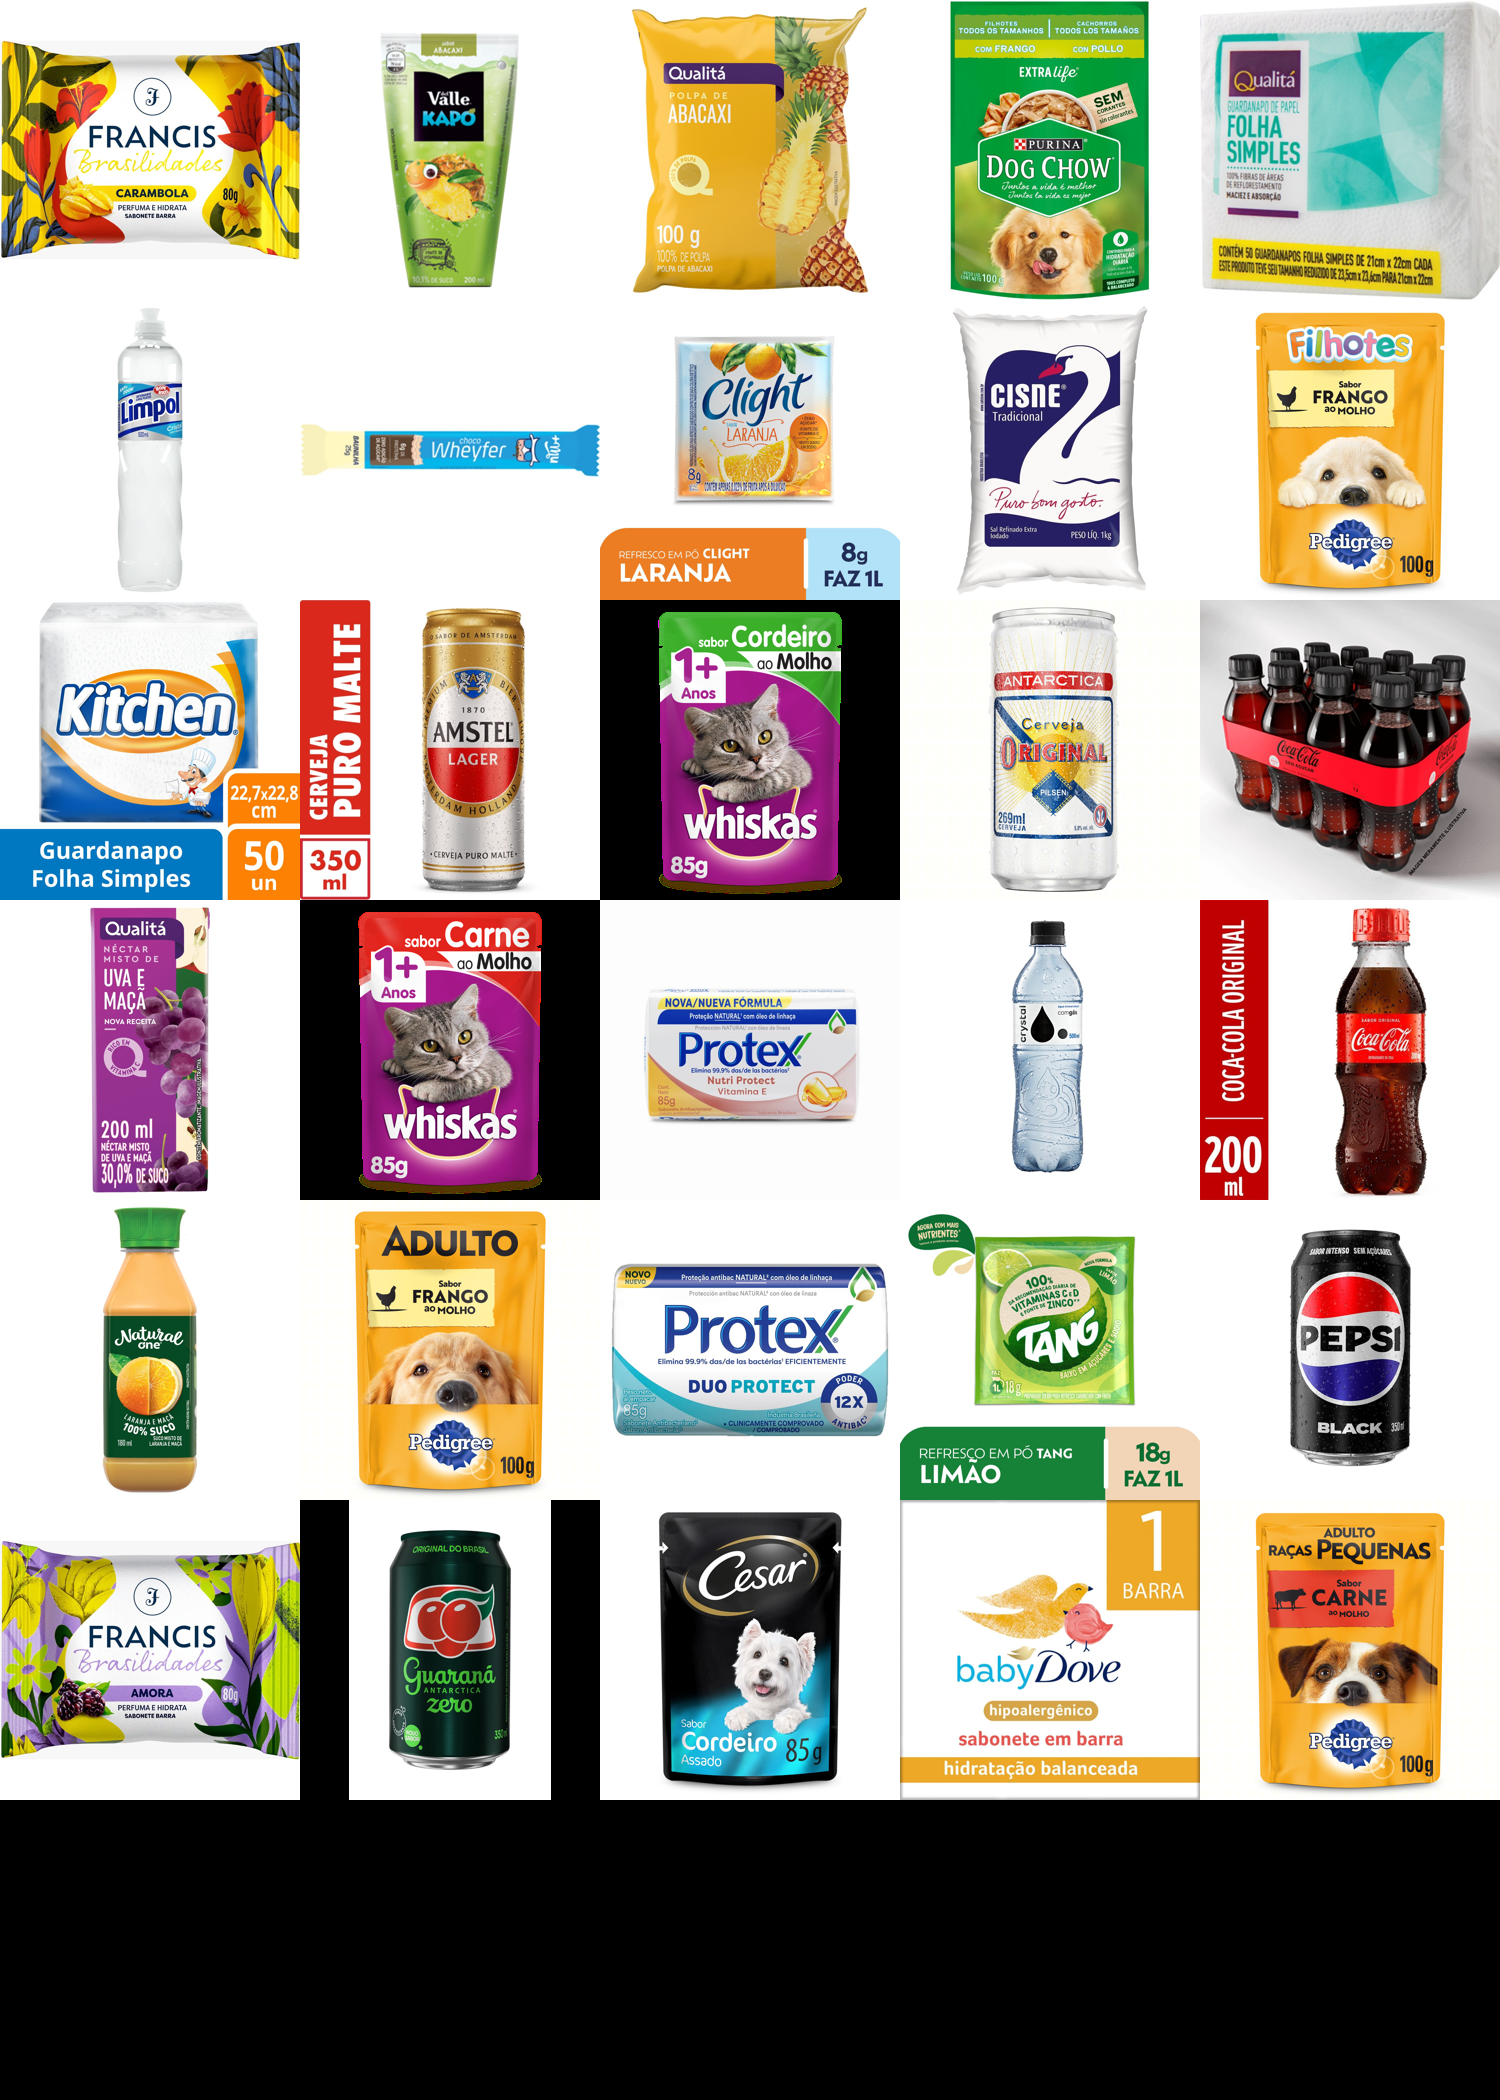

In [273]:
mosaic(best_individual)